In [2]:
import numpy as np
import yaml
import torch
import torch.nn as nn
import torch.nn.functional as F

from competence_estimation.utils import load_data, get_network_weights, mix_open
from competence_estimation.scores  import create_score_function
from competence_estimation.metrics  import compute_metric

import pandas as pd
import matplotlib.pyplot as plt

# Short Introduction

The following files are required:
* {x}_id_train.pt
* {x}_id_val.pt
* {x}_id_test.pt
where x = features, logits, labels

and the same for ood samples:
* {x}_ood
where x = features, logits, labels

Additionally we require the weights w and biases b of the last layer

# Data and Config Loading

In [3]:
with open("config.yml", "r") as file:
    config = yaml.safe_load(file)

# Create Plot

In [5]:
# Here you have to include your own path
# dataset_path = "/home/DATA/ITWM/lorenzp/"
dataset_path = "/home/lorenzp/workspace/competence_estimation/features/svhn"
# algorithm = "ERM"
model = "resnet18"

load_data = model
mode ="spatial"
dataset="svhn"

w = torch.load(f"{dataset_path}/spatial/{model}_W.pt").numpy()
b = torch.load(f"{dataset_path}/spatial/{model}_b.pt").numpy()

print(w.shape, b.shape)

# Features/logits/labels Trainings data
features_id_train =  torch.load(f"{dataset_path}/spatial/features_{mode}_{model}_train.pt")[:30000]
logits_id_train = torch.load(f"{dataset_path}/spatial/logits_{mode}_{model}_train.pt")[:30000]
labels_id_train =  torch.load(f"{dataset_path}/spatial/labels_{mode}_{model}_train.pt")[:30000]

# Features/logits/labels Validation data
features_id_val = torch.load(f"{dataset_path}/spatial/features_{mode}_{model}_train.pt")[30000:]
logits_id_val = torch.load(f"{dataset_path}/spatial/logits_{mode}_{model}_train.pt")[30000:]
labels_id_val = torch.load(f"{dataset_path}/spatial/labels_{mode}_{model}_train.pt")[30000:]

# Features/logits/labels Test data
features_id_test = torch.load(f"{dataset_path}/spatial/features_{mode}_{model}_test.pt")[:5000]
logits_id_test = torch.load(f"{dataset_path}/spatial/logits_{mode}_{model}_test.pt")[:5000]
labels_id_test = torch.load(f"{dataset_path}/spatial/labels_{mode}_{model}_test.pt")[:5000]


print(
    features_id_train.shape,
    features_id_val.shape,
    features_id_test.shape
)

metrics = ['quantiles']
results = {}
results_frac = {}
results_id_test = {}
results_id_test_frac = {}
attacks = ['nor', 'fgsm', 'linfpgd', 'aa', 'linfdf', 'l2df']
# attacks = ['nor', 'fgsm']
score_fct = ["max_softmax", "max_logit", "vim", "mahalanobis", "knn", "energy", "energy_react", "GMM",  "PCA"]
# score_fct = ["max_softmax", "max_logit", "vim"]
# attacks = ['pgd']
# score_fct = [ "vim" ]

features_ood_clean = torch.load(f"{dataset_path}/spatial/features_{mode}_{model}_test.pt")[5000:6000]
logits_ood_clean = torch.load(f"{dataset_path}/spatial/logits_{mode}_{model}_test.pt")[5000:6000]
labels_ood_clean = torch.load(f"{dataset_path}/spatial/labels_{mode}_{model}_test.pt")[5000:6000]


(10, 512) (10,)
(30000, 512) (43257, 512) (5000, 512)


In [9]:

for it, attack in enumerate(attacks):
    print("attack: ", attack)
    results[attack] = {}
    results_frac[attack] = {}
    results_id_test[attack] = {}
    results_id_test_frac[attack] = {}
    
    if it == 0:
        features_ood = torch.load(f"{dataset_path}/spatial/features_{mode}_{model}_test.pt")[5000:10000]
        logits_ood = torch.load(f"{dataset_path}/spatial/logits_{mode}_{model}_test.pt")[5000:10000]
        labels_ood = torch.load(f"{dataset_path}/spatial/labels_{mode}_{model}_test.pt")[5000:10000]
    else:
        features_ood = np.squeeze(torch.load(f"{dataset_path}/spatial/features_{attack}_{mode}_{model}_test.pt"))[5000:10000]
        logits_ood = torch.load(f"{dataset_path}/spatial/logits_{attack}_{mode}_{model}_test.pt")[5000:10000]
        labels_ood = torch.load(f"{dataset_path}/spatial/labels_{attack}_{mode}_{model}_test.pt")[5000:10000]
    
#     if it == 0:
#         features_ood = torch.load(f"{dataset_path}/spatial/features_{mode}_{model}_test.pt")[6000:10000]
#         logits_ood = torch.load(f"{dataset_path}/spatial/logits_{mode}_{model}_test.pt")[6000:10000]
#         labels_ood = torch.load(f"{dataset_path}/spatial/labels_{mode}_{model}_test.pt")[6000:10000]
#     else:
#         features_ood = np.squeeze(torch.load(f"{dataset_path}/spatial/features_{attack}_{mode}_{model}_test.pt"))[6000:10000]
#         logits_ood = torch.load(f"{dataset_path}/spatial/logits_{attack}_{mode}_{model}_test.pt")[6000:10000]
#         labels_ood = torch.load(f"{dataset_path}/spatial/labels_{attack}_{mode}_{model}_test.pt")[6000:10000]
    
    # features_ood = np.vstack((features_ood_clean, features_ood))
    # logits_ood = np.vstack((logits_ood_clean, logits_ood))
    # labels_ood = np.concatenate((labels_ood_clean, labels_ood))  
    
    for it2, score_function_name in enumerate(score_fct):
        scores_id_val, score_function = create_score_function(
            features_id_train,
            logits_id_train,
            labels_id_train,
            features_id_val,
            logits_id_val,
            labels_id_val,
            w,
            b,
            score_function =  score_function_name,
            **config
        )
        scores_id_train = score_function(features_id_train, logits_id_train)
        scores_id_test  = score_function(features_id_test, logits_id_test)
        scores_ood_test = score_function(features_ood, logits_ood)
        
#         print(scores_id_val.shape, scores_id_test.shape)
#         print(features_id_train.shape, features_id_test.shape, features_ood.shape)
#         print(features_ood.shape, logits_ood.shape, labels_ood.shape)
#         print(logits_id_test.shape, labels_id_test.shape)


        outs = compute_metric(
            scores_id_val,
            scores_id_test,
            scores_ood_test,
            features_id_train,
            logits_id_train,
            labels_id_train,
            features_id_test,
            logits_id_test,
            labels_id_test,
            features_ood,
            logits_ood,
            labels_ood,
            metrics=metrics
        )

        print(score_function_name, outs)
        results[attack][score_function_name] = outs['n_95']
        results_frac[attack][score_function_name] = outs['n_95_frac']
        results_id_test[attack][score_function_name] = outs['n_95_id_test']
        results_id_test_frac[attack][score_function_name] = outs['n_95_frac_id_test']

keys = list(results.keys())
methods  = list(results[keys[0]].keys())

table = {}
table_frac = {}

for method in methods: 
    table[method] = []
    table_frac[method] = []
    
    for  key in keys:
        table[method].append(results[key][method])
        table_frac[method].append(results_frac[key][method])

attack:  nor
max_softmax {'n_95_frac': 0.9506, 'n_95': 0.12728802859783173, 'n_95_frac_id_test': 0.949, 'n_95_id_test': 0.129399374127388}
max_logit {'n_95_frac': 0.9412, 'n_95': 0.1270718276500702, 'n_95_frac_id_test': 0.9434, 'n_95_id_test': 0.1299554854631424}
vim {'n_95_frac': 0.9692, 'n_95': 0.1254643052816391, 'n_95_frac_id_test': 0.9694, 'n_95_id_test': 0.12832680344581604}
mahalanobis {'n_95_frac': 0.9674, 'n_95': 0.12569774687290192, 'n_95_frac_id_test': 0.9612, 'n_95_id_test': 0.12942156195640564}
knn {'n_95_frac': 0.9666, 'n_95': 0.12497413903474808, 'n_95_frac_id_test': 0.9666, 'n_95_id_test': 0.12931926548480988}
energy {'n_95_frac': 0.9348, 'n_95': 0.12708601355552673, 'n_95_frac_id_test': 0.9386, 'n_95_id_test': 0.13040699064731598}
energy_react {'n_95_frac': 0.9346, 'n_95': 0.12689921259880066, 'n_95_frac_id_test': 0.9388, 'n_95_id_test': 0.13037921488285065}
GMM {'n_95_frac': 0.9668, 'n_95': 0.1259826272726059, 'n_95_frac_id_test': 0.9608, 'n_95_id_test': 0.12926727533

In [7]:
torch.save(results, '/home/lorenzp/workspace/competence_estimation/results/spatial_svhn.pt')

In [9]:
results = torch.load('/home/lorenzp/workspace/competence_estimation/results/spatial_svhn.pt')

In [ ]:
results_frac

In [ ]:
results_id_test_frac

In [ ]:
keys

In [ ]:
table.keys()

In [ ]:
results['nor']

In [ ]:
results['fgsm']

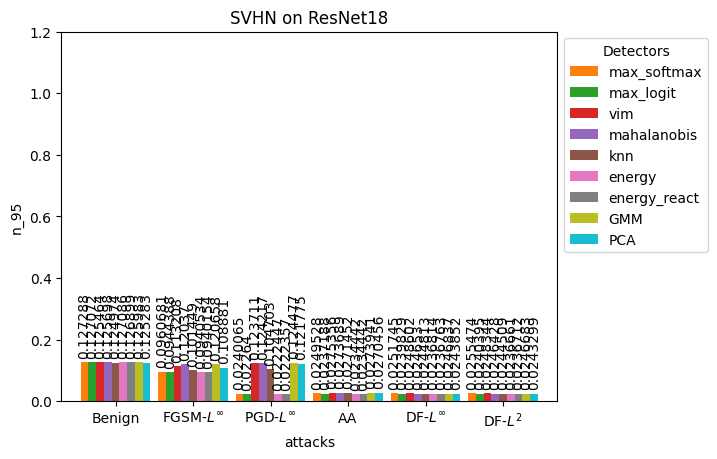

In [7]:
color=["#ff7f0e", "#2ca02c", '#d62728', '#9467bd', "#8c564b", "#e377c2", '#7f7f7f', '#bcbd22', '#17becf'][:len(table)]

raw_data = {
     'plan_type':  ['Benign', 'FGSM-$L^\infty$', 'PGD-$L^\infty$', 'AA', 'DF-$L^\infty$', 'DF-$L^2$'][:len(keys)],
}

for method in methods:
    raw_data[ method] = table[method]

df = pd.DataFrame(raw_data, columns=methods)
ax = df.plot.bar(rot=0, color=color[:len(table)], width=0.9)

for p in ax.patches[0:]:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2.
    if h != 0:
        ax.annotate("%g" % p.get_height(), xy=(x, h), xytext=(0, 3), rotation=90, 
                   textcoords="offset points", ha="center", va="bottom")

plt.title("SVHN on ResNet18")
      
ax.set_ylim(0, 1.2)
ax.legend(title="Detectors", bbox_to_anchor=(1.0, 1), loc='upper left')
ax.set_xticklabels(raw_data["plan_type"])
plt.xlabel("attacks")
plt.ylabel("n_95")

plt.savefig(f"plots/{dataset}_{mode}_{model}_95.png", bbox_inches='tight', dpi=300)

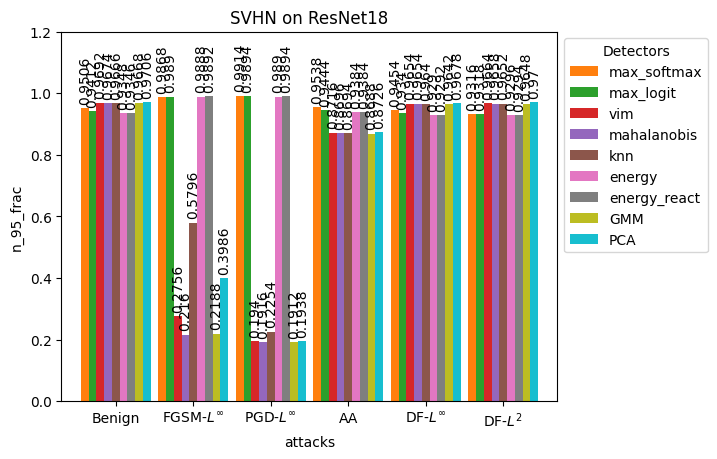

In [8]:
color=["#ff7f0e", "#2ca02c", '#d62728', '#9467bd', "#8c564b", "#e377c2", '#7f7f7f', '#bcbd22', '#17becf'][:len(table)]

raw_data = {
     'plan_type':  ['Benign', 'FGSM-$L^\infty$', 'PGD-$L^\infty$', 'AA', 'DF-$L^\infty$', 'DF-$L^2$'][:len(keys)],
}

for method in methods:
    raw_data[method] = table_frac[method]

df = pd.DataFrame(raw_data, columns=methods)
ax = df.plot.bar(rot=0, color=color[:len(table)], width=0.9)

for p in ax.patches[0:]:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2.
    if h != 0:
        ax.annotate("%g" % p.get_height(), xy=(x, h), xytext=(0, 3), rotation=90, 
                   textcoords="offset points", ha="center", va="bottom")

plt.title("SVHN on ResNet18")
      
ax.set_ylim(0, 1.2)
ax.legend(title="Detectors", bbox_to_anchor=(1.0, 1), loc='upper left')
ax.set_xticklabels(raw_data["plan_type"])
plt.xlabel("attacks")
plt.ylabel("n_95_frac")

plt.savefig(f"plots/{dataset}_{mode}_{model}_95_frac.png", bbox_inches='tight', dpi=300)